# Stat filtering

Following Gurr et al., 2022, looking at the counts/reads info and calculating cpm/filtering using `edgeR`

## 0. load libraries

In [56]:
library(tidyverse)
library(edgeR) 
library(cowplot)

## 1. read CSVs

In [4]:
raw_counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv')
head(raw_counts)

,Gene_ID,Length,B1_B1_O01,B1_Nu_O03,B1_W5_O50,B2_B5_O51,B2_C4_O40,B2_Nu_O12,B3_B4_O41,B3_C3_O30,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_Nu_G41,W6_Nu_G45,W6_W3_G36,W6_W4_G48
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,1017,2,1,6,10,9,16,0,10,⋯,9,2,8,5,2,19,1,2,1,0
2,LOC111126949,4364,885,652,477,654,586,523,392,357,⋯,407,740,707,406,418,424,492,330,281,599
3,LOC111110729,23787,64,209,93,63,100,177,76,98,⋯,70,149,121,115,126,108,118,115,127,213
4,LOC111112434,9649,11,7,2,0,2,2,12,15,⋯,11,6,4,0,2,16,22,0,8,0
5,LOC111120752,6621,360,586,336,426,351,417,236,278,⋯,359,345,438,278,287,416,621,251,333,430
6,LOC111128944,1773,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


In [6]:
dim(raw_counts[3:122]) # 38,838 genes across 120 samples
sum(raw_counts[3:122]) # 5,548,167,947 total read counts across 120 samples

[1] 38838   120

[1] 5548167947

In [8]:
transcript_sums <- colSums(raw_counts[3:122]) # sum of reads for each sample
mean(transcript_sums) # 46234732.9 == average raw read counts for each sample
sd(transcript_sums) # 10347153.2 == standard deviation of raw read counts per sample

[1] 46234733

[1] 10347153

In [11]:
gene_sums_gtr0 <- rowSums(raw_counts[3:122]) > 0 # all gene.IDs with at least one unique read
sum(gene_sums_gtr0 == TRUE) # 35466 total genes with unique transcript reads 
( sum(gene_sums_gtr0 == TRUE) / (dim(raw_counts[3:122])) ) *100 # 91.32 % of genes have a unique mapped read

[1] 35466

[1]    91.31778 29555.00000

## 2. cpm
counts per million with `edgeR`

In [38]:
raw_counts.matrix <- column_to_rownames(raw_counts, 'Gene_ID') %>% # set gene as row name
select(-Length) # remove length column 

head(raw_counts.matrix)

,B1_B1_O01,B1_Nu_O03,B1_W5_O50,B2_B5_O51,B2_C4_O40,B2_Nu_O12,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_Nu_G41,W6_Nu_G45,W6_W3_G36,W6_W4_G48
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,2,1,6,10,9,16,0,10,22,9,⋯,9,2,8,5,2,19,1,2,1,0
LOC111126949,885,652,477,654,586,523,392,357,496,540,⋯,407,740,707,406,418,424,492,330,281,599
LOC111110729,64,209,93,63,100,177,76,98,235,181,⋯,70,149,121,115,126,108,118,115,127,213
LOC111112434,11,7,2,0,2,2,12,15,10,36,⋯,11,6,4,0,2,16,22,0,8,0
LOC111120752,360,586,336,426,351,417,236,278,761,373,⋯,359,345,438,278,287,416,621,251,333,430
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


In [43]:
# splitting phase 1 and phase 2 samples
phase1 <- raw_counts.matrix %>% 
dplyr::select(contains('Nu')) %>%
as.matrix()

phase2 <- raw_counts.matrix %>% 
dplyr::select(!contains('Nu')) %>%
as.matrix()

### finding CPM threshold

In [64]:
# modified from Gurr et al 2022

# For loop ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::;;; #
df_total <- data.frame() # start dataframe 
loop.table <- data.frame(matrix(nrow = 2, ncol = 4)) # create dataframe to save cumunalitively during for loop
colnames(loop.table)<-c('CPM_threshold', 'Phase', 'total_genes', 'mean_reads_per_gene') # names for comuns in the for loop
CPM_loop <- c(0:50)
CPM_loop <- data.frame(CPM_loop)

for (i in 1:nrow(CPM_loop)) {
  
  var <- CPM_loop[i,1]
  
  
  # ========================================================== 
  #
  # PHASE 1 
  # ========================================================== 
  cpm.p1 <- cpm(phase1) # Obtain CPMs (counts oer million) using egdeR
  thresh.p1 <- cpm.p1 > var # Which values in myCPM are greater than 3?
  keep.p1 <- rowSums(thresh.p1) >= (ncol(thresh.p1)/2) # we would like to keep genes that have at least 50% TRUES in each row of thresh
  rowSums(head(thresh.p1)) # Summary of how many TRUEs there are in each row
  table(rowSums(thresh.p1)) 
  cts.matrix.p1.LOOPED <- phase1[keep.p1,]
  
  p1_total_genes           <- nrow(cts.matrix.p1.LOOPED)
  p1_mean_reads_per_gene   <- mean( (rowSums(cts.matrix.p1.LOOPED) / ncol(cts.matrix.p1.LOOPED) ) ) 
  
  # ========================================================== 
  #
  # PHASE 2
  # ========================================================== 
  cpm.p2 <- cpm(phase2) # Obtain CPMs (counts oer million) using egdeR
  thresh.p2 <- cpm.p2 > var # Which values in myCPM are greater than 3?
  keep.p2 <- rowSums(thresh.p2) >= (ncol(thresh.p2)/2) # we would like to keep genes that have at least 50% TRUES in each row of thresh
  rowSums(head(thresh.p2)) # Summary of how many TRUEs there are in each row
  table(rowSums(thresh.p2))  
  cts.matrix.p2.LOOPED <- phase2[keep.p2,]
  
  p2_total_genes           <- nrow(cts.matrix.p2.LOOPED)
  p2_mean_reads_per_gene   <- mean( (rowSums(cts.matrix.p2.LOOPED) / ncol(cts.matrix.p2.LOOPED) ) ) 
    
  loop.table$CPM_threshold           <- c(var, var)
  loop.table$Phase                     <- c(1,2)
  loop.table$total_genes             <- c(p1_total_genes, p2_total_genes)
  loop.table$mean_reads_per_gene   <- c(p1_mean_reads_per_gene, p2_mean_reads_per_gene)
    
  df <- data.frame(loop.table) # name dataframe for this singl e row
  df_total <- rbind(df_total,df) #bind to a cumulative list dataframe
  #print(df_total) # print to monitor progress
}

head(df_total)

,CPM_threshold,Phase,total_genes,mean_reads_per_gene
,<int>,<dbl>,<int>,<dbl>
1,0,1,30106,1821.307
2,0,2,29553,1487.771
3,1,1,20390,2664.360
4,1,2,20247,2137.470
5,2,1,18015,2997.198
6,2,2,17934,2394.959


In [61]:
P1_filterfig <- df_total %>% 
  dplyr::filter(Phase %in% 1) %>% 
  tidyr::gather(key = "variable", value = "measurement",
       total_genes, mean_reads_per_gene, -Phase) %>% 
  # Start with a usual ggplot2 call:
  ggplot(aes(x = CPM_threshold)) +
  geom_line(aes(y = measurement)) +
  ggtitle("Phase1") +
  geom_vline(xintercept = c(3,5,10), color = 'red') +
  facet_wrap(. ~ variable, scales="free")

In [62]:
P2_filterfig <- df_total %>% 
  dplyr::filter(Phase %in% 2) %>% 
  tidyr::gather(key = "variable", value = "measurement",
       total_genes, mean_reads_per_gene, -Phase) %>% 
  # Start with a usual ggplot2 call:
  ggplot(aes(x = CPM_threshold)) +
  geom_line(aes(y = measurement)) +
  ggtitle("Phase2") +
  geom_vline(xintercept = c(3,5,10), color = 'red') +
  facet_wrap(. ~ variable, scales="free")

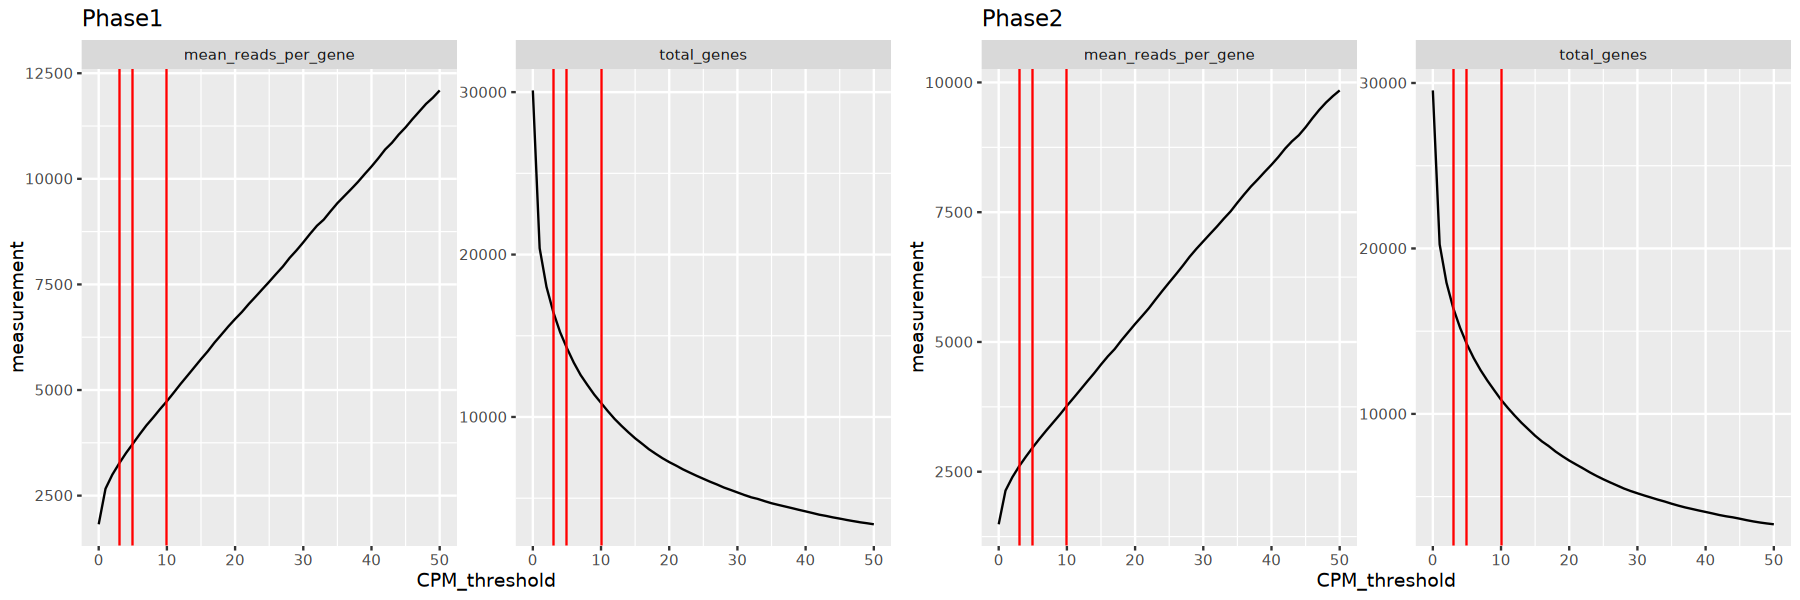

In [60]:
options(repr.plot.width=15, repr.plot.height=5)

plot_grid(P1_filterfig, P2_filterfig)

In [66]:
CPM.all <- cpm(raw_counts.matrix) # Obtain CPMs (counts oer million) using egdeR
head(CPM.all) # Have a look at the output


,B1_B1_O01,B1_Nu_O03,B1_W5_O50,B2_B5_O51,B2_C4_O40,B2_Nu_O12,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_Nu_G41,W6_Nu_G45,W6_W3_G36,W6_W4_G48
LOC111116054,0.04591336,0.01636313,0.14389515,0.2149825,0.19763800,0.25483028,0.0000000,0.2573056,0.3368047,0.2313798,⋯,0.2537614,0.04853452,0.18759129,0.1272553,0.04831845,0.4849496,0.0181573,0.04719932,0.02671504,0.000000
LOC111126949,20.31666355,10.66876254,11.43966451,14.0598576,12.86842962,8.32976465,10.1531391,9.1858092,7.5934141,13.8827891,⋯,11.4756557,17.95777094,16.57837995,10.3331328,10.09855684,10.8220332,8.9333927,7.78788758,7.50692668,14.392580
LOC111110729,1.46922765,3.41989474,2.23037484,1.3543900,2.19597775,2.81905993,1.9684657,2.5215947,3.5976861,4.6533052,⋯,1.9737000,3.61582145,2.83731821,2.9268726,3.04406259,2.7565556,2.1425617,2.71396082,3.39281028,5.117896
LOC111112434,0.25252350,0.11454193,0.04796505,0.0000000,0.04391956,0.03185378,0.3108104,0.3859584,0.1530930,0.9255193,⋯,0.3101529,0.14560355,0.09379564,0.0000000,0.04831845,0.4083786,0.3994606,0.00000000,0.21372033,0.000000
LOC111120752,8.26440551,9.58879578,8.05812846,9.1582559,7.70788190,6.64151407,6.1126042,7.1530951,11.6503793,9.5894080,⋯,10.1222614,8.37220402,10.27062294,7.0753964,6.93369812,10.6178439,11.2756847,5.92351450,8.89610884,10.331902
LOC111128944,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,⋯,0.0000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,0.0000000,0.02359966,0.00000000,0.000000


In [73]:
thresh.all <- CPM.all > 3 # Which values in myCPM are greater than 3?
head(thresh.all) # This produces a logical matrix with TRUEs and FALSES

rowSums(head(thresh.all)) # Summary of how many TRUEs there are in each row
sum(rowSums(thresh.all) == ncol(thresh.all)) # 2907 genes with TRUE in all 120 samples 

keep.all <- rowSums(thresh.all) >= (ncol(thresh.all)/2) # we would like to keep genes that have at least 50% TRUES in each row of thresh
summary(keep.all) # FALSE 22501 & TRUE  16337 -- half of the genes did not pass
raw_counts.matrix.filtered <- raw_counts.matrix[keep.all,] # Subset the rows of countdata to keep the more highly expressed genes

,B1_B1_O01,B1_Nu_O03,B1_W5_O50,B2_B5_O51,B2_C4_O40,B2_Nu_O12,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_Nu_G41,W6_Nu_G45,W6_W3_G36,W6_W4_G48
LOC111116054,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
LOC111126949,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,⋯,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
LOC111110729,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,⋯,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE
LOC111112434,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
LOC111120752,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,⋯,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
LOC111128944,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


LOC111116054 LOC111126949 LOC111110729 LOC111112434 LOC111120752 LOC111128944 
           0          119           31            0          118            0

[1] 2907

   Mode   FALSE    TRUE 
logical   22501   16337 